In [68]:
import pandas as pd
import numpy as np
import datetime as dt

In [69]:
# Lists below to use in functions below to pull data for
# January - June in the years of 2018, 2019, 2020
# Run cell to use lists later.

# MTA weeks to pull to create 2020 files
week_nums_2020 = [200104, 200111, 200118, 200125, 200201, 
                  200208, 200215, 200222, 200229, 200307, 
                  200314, 200321, 200328, 200404, 200411, 
                  200418, 200425, 200502, 200509, 200516, 
                  200523, 200530, 200606, 200613, 200620, 
                  200627]

# MTA weeks to pull to create 2019 files
week_nums_2019 = [190105, 190112, 190119, 190126, 190202, 
                  190209, 190216, 190223, 190302, 190309, 
                  190316, 190323, 190330, 190406, 190413, 
                  190420, 190427, 190504, 190511, 190518, 
                  190525, 190601, 190608, 190615, 190622, 
                  190629]

# MTA weeks to pull to create 2018 files
week_nums_2018 = [180106, 180113, 180120, 180127, 180203, 
                  180210, 180217, 180224, 180303, 180310, 
                  180317, 180324, 180331, 180407, 180414, 
                  180421, 180428, 180505, 180512, 180519, 
                  180526, 180602, 180609, 180616, 180623, 
                  180630]

In [70]:
# Function that will do bulk-pull of MTA data for 
# multiple weeks.  Run cell for use later in 'master'
# function.

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

## SMALL FUNCTIONS NEEDED MASTER FUNCTIONS

In [71]:
# Run this cell -- must be done before running 
# functions below. This function and one below
# (get_day_exit_counts()) will be used in 'master'
# functions below

def get_day_entry_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter


In [72]:
# As noted in previous cell, run this function before
# running 'master' functions

def get_day_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        return 0
    return counter

## MASTER FUNCTION FOR STATION-ONLY DF

In [73]:
# 'Master' function to get data for target stations
# that are not line-dependent


def get_yearly_data_station_only(list_of_weeks):
    '''
    Input: A list of dates that match the end of the 
    MTA raw data files that you want to pull from in the 
    format YYMMDD, such as "200104."
    
    Output: will be a dataframe that lists only data
    for the stations: Times Sq, Grand Central, Lexington,
    34 St. Herald, St.Union, 59 St Columbus, and Penn
    Station.  For those stations will also see:
    1. Date
    2. Daily Entries
    3. Daily Exits
    4. Week Of date
    5. Total Traffic (Entries + Exits)
    '''
    df = get_data(list_of_weeks)
    
    # create df with only stations focusing on
    df_stations = df[(df.STATION == 'TIMES SQ-42 ST')
                     |(df.STATION == 'GRD CNTRL-42 ST')
                     |(df.STATION == 'LEXINGTON AV/53')
                     |(df.STATION == '34 ST-HERALD SQ')
                     |(df.STATION == '14 ST-UNION SQ')
                     |(df.STATION == '59 ST COLUMBUS')
                     |(df.STATION == '34 ST-PENN STA')]


    df_stations.rename(columns={df_stations.columns[10]: 'EXITS'}
                       , inplace=True)

    
    # find first entry for entries and exits
    day_counts_df = df_stations.groupby(['C/A','UNIT','SCP','STATION','DATE']
                                    ,as_index=False)[['ENTRIES','EXITS']].first()
    
    # get the ENTRY daily summary data of each turnstile
    day_counts_df[['PREV_ENTRY_DATE', 'PREV_ENTRIES']] = (day_counts_df
                                                          .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES']
                                                          .apply(lambda grp: grp.shift(1)))
   
    # get the EXIT daily summary data of each turnstile
    day_counts_df[['PREV_EXIT_DATE', 'PREV_EXITS']] = (day_counts_df
                                                       .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))
    
    
    # drop nan where applicable in new previous date columns for entries & exits
    day_counts_df.dropna(subset=['PREV_ENTRY_DATE'], inplace=True)
    day_counts_df.dropna(subset=['PREV_EXIT_DATE'], inplace=True)
    

    #create new columns for daily entries and daily exits
    day_counts_df["DAILY_ENTRIES"] = (day_counts_df
                                            .apply(get_day_entry_counts, axis=1, max_counter=100_000))
    
    day_counts_df["DAILY_EXITS"] = (day_counts_df
                                    .apply(get_day_exit_counts, axis=1, max_counter=100_000))
    
    
    # set datetime data
    day_counts_df['DATE'] = pd.to_datetime(day_counts_df['DATE'])
    
    
    # get the daily summary data of station
    daily_sum_stations = day_counts_df.groupby(
        ['STATION','DATE'])[['DAILY_ENTRIES','DAILY_EXITS']].sum().reset_index()
    
    # get the fist day of the week & place in new 'WeekOf' column
    daily_sum_stations['weekday'] = daily_sum_stations['DATE'].dt.dayofweek
    daily_sum_stations['WeekOf'] = daily_sum_stations['DATE']
    daily_sum_stations.loc[daily_sum_stations.weekday != 0, 'WeekOf'] = ''
    daily_sum_stations = daily_sum_stations.replace('',np.nan).ffill()
    daily_sum_stations['WeekOf'] = pd.to_datetime(daily_sum_stations['WeekOf']).dt.date
#     daily_sum_stations = daily_sum_stations[daily_sum_stations.WeekOf.notnull()]
    
    # get total Traffic (= entries + exits) & place in new 'TotalTraffic' column
    daily_sum_stations['TotalTraffic'] = (daily_sum_stations['DAILY_ENTRIES'] 
                                          + daily_sum_stations['DAILY_EXITS'])
    
    
    return daily_sum_stations

In [74]:
# create dataframes for stations Times Sq, Grand Central, Lexington,
# 34 St. Herald, St.Union, 59 St Columbus, and Penn Station.  
# Data will be for total Jan - June timeframe for each year.

stations_2020 = get_yearly_data_station_only(week_nums_2020)
stations_2019 = get_yearly_data_station_only(week_nums_2019)
stations_2018 = get_yearly_data_station_only(week_nums_2018)

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
with open('noise.pickle', 'wb') as to_write:
    pickle.dump(lots_of_noise, to_write)

## FULTON ST

In [75]:
def get_yearly_data_fulton(list_of_weeks):
    '''
    Input: A list of dates that match the end of the 
    MTA raw data files that you want to pull from in the 
    format YYMMDD, such as "200104."
    
    Output: will be a dataframe that lists only data
    for the Fulton St's lines: 'ACJZ2345'
    and '2345ACJZ'.  Data for two lines will be 
    combined under Fulton as one.  Will also see:
    1. Date
    2. Daily Entries
    3. Daily Exits
    4. Week Of date
    5. Total Traffic (Entries + Exits)
    '''
    df = get_data(list_of_weeks)
    
    # create df with only stations focusing on
    df_stations = df[(df.STATION == "FULTON ST")]
    # get the lines we need for "FULTON ST"
    df_stations = df_stations[(df_stations.LINENAME == 'ACJZ2345')
                                     |(df_stations.LINENAME == '2345ACJZ')]

    df_stations.rename(columns={df_stations.columns[10]: 'EXITS'}
                       , inplace=True)

    
    # find first entry for entries and exits
    day_counts_df = df_stations.groupby(['C/A','UNIT','SCP','STATION','DATE']
                                    ,as_index=False)[['ENTRIES','EXITS']].first()
    
    # get the ENTRY daily summary data of each turnstile
    day_counts_df[['PREV_ENTRY_DATE', 'PREV_ENTRIES']] = (day_counts_df
                                                          .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES']
                                                          .apply(lambda grp: grp.shift(1)))
   
    # get the EXIT daily summary data of each turnstile
    day_counts_df[['PREV_EXIT_DATE', 'PREV_EXITS']] = (day_counts_df
                                                       .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))
    
    
    # drop nan where applicable in new previous date columns for entries & exits
    day_counts_df.dropna(subset=['PREV_ENTRY_DATE'], inplace=True)
    day_counts_df.dropna(subset=['PREV_EXIT_DATE'], inplace=True)
    

    #create new columns for daily entries and daily exits
    day_counts_df["DAILY_ENTRIES"] = (day_counts_df
                                            .apply(get_day_entry_counts, axis=1, max_counter=100_000))
    
    day_counts_df["DAILY_EXITS"] = (day_counts_df
                                    .apply(get_day_exit_counts, axis=1, max_counter=100_000))
    
    
    # set datetime data
    day_counts_df['DATE'] = pd.to_datetime(day_counts_df['DATE'])
    
    
    # get the daily summary data of station
    daily_sum_stations = day_counts_df.groupby(
        ['STATION','DATE'])[['DAILY_ENTRIES','DAILY_EXITS']].sum().reset_index()
    
    # get the fist day of the week & place in new 'WeekOf' column
    daily_sum_stations['weekday'] = daily_sum_stations['DATE'].dt.dayofweek
    daily_sum_stations['WeekOf'] = daily_sum_stations['DATE']
    daily_sum_stations.loc[daily_sum_stations.weekday != 0, 'WeekOf'] = ''
    daily_sum_stations = daily_sum_stations.replace('',np.nan).ffill()
    daily_sum_stations['WeekOf'] = pd.to_datetime(daily_sum_stations['WeekOf']).dt.date
    daily_sum_stations = daily_sum_stations[daily_sum_stations.WeekOf.notnull()]
    
    # get total Traffic (= entries + exits) & place in new 'TotalTraffic' column
    daily_sum_stations['TotalTraffic'] = (daily_sum_stations['DAILY_ENTRIES'] 
                                          + daily_sum_stations['DAILY_EXITS'])
    
    
    return daily_sum_stations

In [76]:
# create dataframes for Fulton Station's specified lines  
# Data will be for total Jan - June timeframe for each year.

fulton_2020 = get_yearly_data_fulton(week_nums_2020)
fulton_2019 = get_yearly_data_fulton(week_nums_2019)
fulton_2018 = get_yearly_data_fulton(week_nums_2018)

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


## CHAMBERS ST

In [28]:
def get_yearly_data_chambers(list_of_weeks):
    '''
    Input: A list of dates that match the end of the 
    MTA raw data files that you want to pull from in the 
    format YYMMDD, such as "200104."
    
    Output: will be a dataframe that lists only data
    for the Chambers' lines: 'JZ456'and 'ACE23'.  Data 
    for two lines will be combined under Chambers as one.  
    Will also see:
    1. Date
    2. Daily Entries
    3. Daily Exits
    4. Week Of date
    5. Total Traffic (Entries + Exits)
    '''
    df = get_data(list_of_weeks)
    
    # create df with only stations focusing on
    df_stations = df[(df.STATION == "CHAMBERS ST")]
    # get the lines we need for "CHAMBERS ST"
    df_stations = df_stations[(df_stations.LINENAME == 'JZ456')
                                     |(df_stations.LINENAME == 'ACE23')]

    df_stations.rename(columns={df_stations.columns[10]: 'EXITS'}
                       , inplace=True)

    
    # find first entry for entries and exits
    day_counts_df = df_stations.groupby(['C/A','UNIT','SCP','STATION','DATE']
                                    ,as_index=False)[['ENTRIES','EXITS']].first()
    
    # get the ENTRY daily summary data of each turnstile
    day_counts_df[['PREV_ENTRY_DATE', 'PREV_ENTRIES']] = (day_counts_df
                                                          .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES']
                                                          .apply(lambda grp: grp.shift(1)))
   
    # get the EXIT daily summary data of each turnstile
    day_counts_df[['PREV_EXIT_DATE', 'PREV_EXITS']] = (day_counts_df
                                                       .groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))
    
    
    # drop nan where applicable in new previous date columns for entries & exits
    day_counts_df.dropna(subset=['PREV_ENTRY_DATE'], inplace=True)
    day_counts_df.dropna(subset=['PREV_EXIT_DATE'], inplace=True)
    

    #create new columns for daily entries and daily exits
    day_counts_df["DAILY_ENTRIES"] = (day_counts_df
                                            .apply(get_day_entry_counts, axis=1, max_counter=100_000))
    
    day_counts_df["DAILY_EXITS"] = (day_counts_df
                                    .apply(get_day_exit_counts, axis=1, max_counter=100_000))
    
    
    # set datetime data
    day_counts_df['DATE'] = pd.to_datetime(day_counts_df['DATE'])
    
    
    # get the daily summary data of station
    daily_sum_stations = day_counts_df.groupby(
        ['STATION','DATE'])[['DAILY_ENTRIES','DAILY_EXITS']].sum().reset_index()
    
    # get the fist day of the week & place in new 'WeekOf' column
    daily_sum_stations['weekday'] = daily_sum_stations['DATE'].dt.dayofweek
    daily_sum_stations['WeekOf'] = daily_sum_stations['DATE']
    daily_sum_stations.loc[daily_sum_stations.weekday != 0, 'WeekOf'] = ''
    daily_sum_stations = daily_sum_stations.replace('',np.nan).ffill()
    daily_sum_stations['WeekOf'] = pd.to_datetime(daily_sum_stations['WeekOf']).dt.date
    daily_sum_stations = daily_sum_stations[daily_sum_stations.WeekOf.notnull()]
    
    # get total Traffic (= entries + exits) & place in new 'TotalTraffic' column
    daily_sum_stations['TotalTraffic'] = (daily_sum_stations['DAILY_ENTRIES'] 
                                          + daily_sum_stations['DAILY_EXITS'])
    
    
    return daily_sum_stations

In [29]:
# create dataframes for Chambers St Station's specified lines  
# Data will be for total late Dec - June timeframe for each year.

chambers_2020 = get_yearly_data_chambers(week_nums_2020)
chambers_2019 = get_yearly_data_chambers(week_nums_2019)
chambers_2018 = get_yearly_data_chambers(week_nums_2018)

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


# BY YEAR (ALL STATIONS)

In [30]:
# Combine dataframes from all stations by year; add year and month column

df_2020 = pd.concat([stations_2020,fulton_2020,chambers_2020])
df_2020['Month'] = df_2020['DATE'].dt.month
df_2020['Year'] = df_2020['DATE'].dt.year

df_2019 = pd.concat([stations_2019,fulton_2019,chambers_2019])
df_2019['Month'] = df_2019['DATE'].dt.month
df_2019['Year'] = df_2019['DATE'].dt.year

df_2018 = pd.concat([stations_2018,fulton_2018,chambers_2018])
df_2018['Month'] = df_2018['DATE'].dt.month
df_2018['Year'] = df_2018['DATE'].dt.year

In [31]:
df_2020

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,weekday,WeekOf,TotalTraffic,Month,Year
0,14 ST-UNION SQ,2019-12-28,732440.0,712065.0,5,NaT,1444505.0,12,2019
1,14 ST-UNION SQ,2019-12-29,57403.0,59200.0,6,NaT,116603.0,12,2019
2,14 ST-UNION SQ,2019-12-30,44631.0,46257.0,0,2019-12-30,90888.0,12,2019
3,14 ST-UNION SQ,2019-12-31,70105.0,71541.0,1,2019-12-30,141646.0,12,2019
4,14 ST-UNION SQ,2020-01-02,37686.0,37133.0,3,2019-12-30,74819.0,1,2020
...,...,...,...,...,...,...,...,...,...
176,CHAMBERS ST,2020-06-22,1203.0,1449.0,0,2020-06-22,2652.0,6,2020
177,CHAMBERS ST,2020-06-23,4025.0,3959.0,1,2020-06-22,7984.0,6,2020
178,CHAMBERS ST,2020-06-24,4525.0,4560.0,2,2020-06-22,9085.0,6,2020
179,CHAMBERS ST,2020-06-25,4704.0,4721.0,3,2020-06-22,9425.0,6,2020


In [32]:
df_2019.head(10)

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,weekday,WeekOf,TotalTraffic,Month,Year
0,14 ST-UNION SQ,2018-12-29,242191.0,302351.0,5,NaT,544542.0,12,2018
1,14 ST-UNION SQ,2018-12-30,67244.0,66070.0,6,NaT,133314.0,12,2018
2,14 ST-UNION SQ,2018-12-31,53561.0,53346.0,0,2018-12-31,106907.0,12,2018
3,14 ST-UNION SQ,2019-01-02,39019.0,35104.0,2,2018-12-31,74123.0,1,2019
4,14 ST-UNION SQ,2019-01-03,89088.0,77360.0,3,2018-12-31,166448.0,1,2019
5,14 ST-UNION SQ,2019-01-04,95217.0,82795.0,4,2018-12-31,178012.0,1,2019
6,14 ST-UNION SQ,2019-01-05,98482.0,87190.0,5,2018-12-31,185672.0,1,2019
7,14 ST-UNION SQ,2019-01-06,58167.0,54848.0,6,2018-12-31,113015.0,1,2019
8,14 ST-UNION SQ,2019-01-07,50724.0,45642.0,0,2019-01-07,96366.0,1,2019
9,14 ST-UNION SQ,2019-01-08,93320.0,80561.0,1,2019-01-07,173881.0,1,2019


In [31]:
df_2018.head(10)

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,weekday,WeekOf,TotalTraffic,Month,Year
8,14 ST-UNION SQ,2018-01-08,49082.0,45883.0,0,2018-01-08,94965.0,1,2018
9,14 ST-UNION SQ,2018-01-09,97726.0,84123.0,1,2018-01-08,181849.0,1,2018
10,14 ST-UNION SQ,2018-01-10,103866.0,90425.0,2,2018-01-08,194291.0,1,2018
11,14 ST-UNION SQ,2018-01-11,106803.0,91299.0,3,2018-01-08,198102.0,1,2018
12,14 ST-UNION SQ,2018-01-12,106578.0,90986.0,4,2018-01-08,197564.0,1,2018
13,14 ST-UNION SQ,2018-01-13,100614.0,90028.0,5,2018-01-08,190642.0,1,2018
14,14 ST-UNION SQ,2018-01-14,69894.0,67517.0,6,2018-01-08,137411.0,1,2018
15,14 ST-UNION SQ,2018-01-15,54352.0,50674.0,0,2018-01-15,105026.0,1,2018
16,14 ST-UNION SQ,2018-01-16,66394.0,61049.0,1,2018-01-15,127443.0,1,2018
17,14 ST-UNION SQ,2018-01-17,101795.0,88516.0,2,2018-01-15,190311.0,1,2018


# MONTHLY DATA BY YEAR

In [33]:
month_2020 = df_2020[df_2020.Year == 2020].groupby('Month')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
month_2020

,Month,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,1,20654050.0,19685059.0,40339109.0
1,2,20298945.0,19632178.0,39931123.0
2,3,10284978.0,10302671.0,20587649.0
3,4,1135377.0,1391862.0,2527239.0
4,5,1469435.0,1797905.0,3267340.0
5,6,1947129.0,2374016.0,4321145.0


In [34]:
month_2019 = df_2019[df_2019.Year == 2019].groupby('Month')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
month_2019

,Month,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,1,21188622.0,18810963.0,39999585.0
1,2,20697755.0,18442718.0,39140473.0
2,3,24562569.0,22043488.0,46606057.0
3,4,23671014.0,21501554.0,45172568.0
4,5,24498191.0,22078580.0,46576771.0
5,6,22161651.0,20176377.0,42338028.0


In [35]:
month_2018 = df_2018[df_2018.Year == 2018].groupby('Month')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
month_2018

,Month,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,1,20425727.0,17857713.0,38283440.0
1,2,20758426.0,18052471.0,38810897.0
2,3,23713220.0,20589386.0,44302606.0
3,4,22843315.0,19868763.0,42712078.0
4,5,24565664.0,21253159.0,45818823.0
5,6,23134758.0,20345568.0,43480326.0


# WEEKLY DATA BY YEAR

In [36]:
week_2020 = df_2020.groupby('WeekOf')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
week_2020

,WeekOf,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,2019-12-30,3504782.0,3313236.0,6818018.0
1,2020-01-06,5058707.0,4779633.0,9838340.0
2,2020-01-13,4948852.0,4701363.0,9650215.0
3,2020-01-20,4555317.0,4376686.0,8932003.0
4,2020-01-27,4994646.0,4781575.0,9776221.0
5,2020-02-03,4961917.0,4773806.0,9735723.0
6,2020-02-10,4965916.0,4855202.0,9821118.0
7,2020-02-17,4546677.0,4465291.0,9011968.0
8,2020-02-24,4999889.0,4773004.0,9772893.0
9,2020-03-02,4723797.0,4611852.0,9335649.0


In [37]:
week_2019 = df_2019.groupby('WeekOf')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
week_2019

,WeekOf,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,2018-12-31,3809817.0,3425409.0,7235226.0
1,2019-01-07,5129024.0,4516335.0,9645359.0
2,2019-01-14,5121649.0,4514471.0,9636120.0
3,2019-01-21,4621665.0,4153198.0,8774863.0
4,2019-01-28,5150953.0,4557903.0,9708856.0
5,2019-02-04,5314517.0,4710271.0,10024788.0
6,2019-02-11,5335281.0,4656551.0,9991832.0
7,2019-02-18,4867225.0,4478640.0,9345865.0
8,2019-02-25,5289548.0,4707548.0,9997096.0
9,2019-03-04,5600253.0,4946725.0,10546978.0


In [52]:
week_2018 = df_2018.groupby('WeekOf')[['DAILY_ENTRIES','DAILY_EXITS','TotalTraffic']].sum().reset_index()
week_2018

,WeekOf,DAILY_ENTRIES,DAILY_EXITS,TotalTraffic
0,2018-01-08,5175010.0,4522692.0,9697702.0
1,2018-01-15,4864192.0,4258102.0,9122294.0
2,2018-01-22,5194545.0,4516874.0,9711419.0
3,2018-01-29,5328023.0,4556235.0,9884258.0
4,2018-02-05,5250558.0,4542208.0,9792766.0
5,2018-02-12,5266080.0,4622255.0,9888335.0
6,2018-02-19,4884151.0,4303406.0,9187557.0
7,2018-02-26,5240046.0,4544697.0,9784743.0
8,2018-03-05,5101346.0,4441453.0,9542799.0
9,2018-03-12,5495999.0,4792400.0,10288399.0


# ALL YEARS

In [38]:
df_all = pd.concat([df_2020, df_2019, df_2018])

In [39]:
df_all

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,weekday,WeekOf,TotalTraffic,Month,Year
0,14 ST-UNION SQ,2019-12-28,732440.0,712065.0,5,NaT,1444505.0,12,2019
1,14 ST-UNION SQ,2019-12-29,57403.0,59200.0,6,NaT,116603.0,12,2019
2,14 ST-UNION SQ,2019-12-30,44631.0,46257.0,0,2019-12-30,90888.0,12,2019
3,14 ST-UNION SQ,2019-12-31,70105.0,71541.0,1,2019-12-30,141646.0,12,2019
4,14 ST-UNION SQ,2020-01-02,37686.0,37133.0,3,2019-12-30,74819.0,1,2020
...,...,...,...,...,...,...,...,...,...
176,CHAMBERS ST,2018-06-25,10716.0,13321.0,0,2018-06-25,24037.0,6,2018
177,CHAMBERS ST,2018-06-26,40778.0,31157.0,1,2018-06-25,71935.0,6,2018
178,CHAMBERS ST,2018-06-27,44115.0,33793.0,2,2018-06-25,77908.0,6,2018
179,CHAMBERS ST,2018-06-28,42595.0,32038.0,3,2018-06-25,74633.0,6,2018


# ANALYSIS

In [41]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

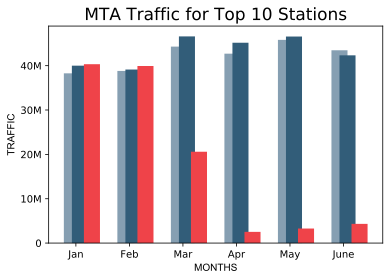

In [67]:
# Create a bar chart of all traffic by month for all 3 years
# If want legend, add: plt.legend(['2018','2019','2020'],shadow = True, loc = 0)
# Keep in mind "top 10 stations" in title is in reference
# to MTA's 2019 report on most-trafficked stations

width = 0.30

x = np.arange(len(month_2018.TotalTraffic)) # this isn't the correct way to make the x labels! Just testing look

fig, ax = plt.subplots()
bar18 = ax.bar(x - width/4, month_2018.TotalTraffic, width, label='2018', color='#869fb2ff')
bar19 = ax.bar(x + width/4, month_2019.TotalTraffic, width, label='2019', color='#325d79ff')
bar20 = ax.bar(x + width, month_2020.TotalTraffic, width, label='2020', color='#ef4349ff')
plt.title('MTA Traffic for Top 10 Stations', size=17)
plt.xlabel("MONTHS", size=10, family='arial')
ax.set_xticklabels(["n/a","Jan","Feb","Mar","Apr","May","June","July"])
ax.set_yticklabels(["0","10M","20M","30M","40M"])
plt.ylabel("TRAFFIC", size=10, family='arial')
plt.savefig('totaltraffic_monthly.jpg', bbox_inches="tight")
plt.savefig('totaltraffic_monthly.svg', bbox_inches="tight");